In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [70]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import utils
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from transformers import PreTrainedTokenizerFast
import torchvision.models
from torchsummary import summary

# 시각화 관련
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 
from tqdm.notebook import tqdm
from PIL import Image

# 영상관련
from IPython.display import HTML
import matplotlib.animation as animation

# arange 기본
import numpy as np
import pandas as pd

# 그외
import os
import random
import tqdm
from glob import glob
import h5py
import zipfile
import imageio
import os

In [ ]:
USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [ ]:
# 캐글 json으로 산타클로스 데이터 불러오기
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

Saving kaggle.json to kaggle.json
 99% 201M/203M [00:10<00:00, 23.4MB/s]
100% 203M/203M [00:10<00:00, 19.4MB/s]


In [ ]:
# 이미지를 516으로 추립니다.
# 시간 주의 
%%time
hdf5_file = '/content/mount/My Drive/Colab Notebooks/test.h5py'
total_images = 614

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/is-that-santa-image-classification.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('is that santa/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%10 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass
     
     

CPU times: user 2min 20s, sys: 3.48 s, total: 2min 23s
Wall time: 2min 52s


In [ ]:
!unzip /content/is-that-santa-image-classification.zip

Archive:  /content/is-that-santa-image-classification.zip
  inflating: is that santa/test/not-a-santa/0.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/1.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/100.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/103.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/104.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/105.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/107.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/109.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/110.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/111.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/113.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/114.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/115.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/116.not-a-santa.jpg  
  inflating: is that s

In [ ]:
if torch.cuda.is_available():
   torch.set_default_tensor_type(torch.cuda.FloatTensor)
   print('using cuda:', torch.cuda.get_device_name(0))

using cuda: Tesla T4


In [ ]:
santa_imgs = ImageFolder('/content/is that santa/',
                         transform = transforms.Compose([
                             transforms.ToTensor()]))
train_loader = DataLoader(santa_imgs, batch_size = 1, shuffle = True)

In [ ]:
santa_imgs[0][0].shape

torch.Size([3, 2332, 2332])

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data = data_path
        self.label = [int(p.split('/')[-2] == 'santa') for p in data_path]
        self.data_len = len(self.data)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        image = Image.open(self.data[index], mode='r')
        image = image.convert('RGB')
        
        
        if self.transform:
            image = self.transform(image)
            
        self.label[index] = np.array(self.label[index])
        return image, torch.from_numpy(self.label[index])

In [ ]:
class CelebADataset(Dataset):
     def __init__(self, file):
         self.file_object = h5py.File(file, 'r')
         self.dataset = self.file_object['img_align_celeba']
         pass

     def __len__(self):
         return len(self.dataset)

     def __getitem__(self, index):
         if (index >= len(self.dataset)):
            raise IndexError()
         img = np.array(self.dataset[str(index)+'.jpg'])
         return torch.cuda.FloatTensor(img) / 255.0

     def plot_image(self, index):
         plt.imshow(np.array(self.dataset[str(index)+'.jpg']),
                    interpolation = 'nearest')
         pass
     pass 
     

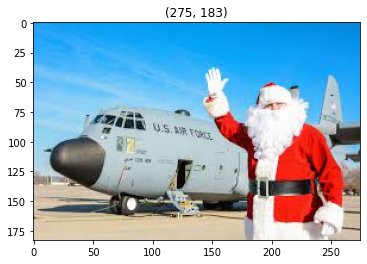

In [ ]:
# 산타 이미지만 불러오기 

train_mother_path = '/content/is that santa/train/'
test_mother_path = '/content/is that santa/test/'

train_image_path = glob(os.path.join(train_mother_path, 'santa', '*'))
test_image_path = glob(os.path.join(test_mother_path, 'santa', '*'))

idx = np.random.randint(0, len(train_image_path))
image = Image.open(train_image_path[idx])
plt.imshow(image)
plt.title(image.size)
plt.show()

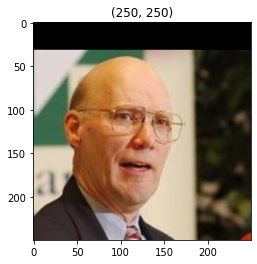

In [ ]:
# 테스트 폴더에서는 비 산타만 불러오기
test_image_path = glob(os.path.join(test_mother_path, 'not-a-santa', '*'))

idx = np.random.randint(0, len(test_image_path))
image = Image.open(test_image_path[idx])
plt.imshow(image)
plt.title(image.size)
plt.show()

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [ ]:
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

In [ ]:
trainData

In [ ]:
# Discriminator 부터 시작

# 3차원을 1차원으로 만드는 클래스
class View(nn.Module):
   def __init__(self, shape):
       super().__init__()
       self.shape = shape,

   def forward(self, x):
       return x.view(*self.shape)

In [ ]:
# 이미지 크기는 224 * 224였음
class Discriminator(nn.Module):
   def __init__(self):
       super().__init__()
       self.model = nn.Sequential(
           View(224*224*3), # view 클래스 제외
           nn.Linear(3*224*224,100),
           nn.LeakyReLU(),
           nn.LayerNorm(100),
           nn.Linear(100,1),
           nn.Sigmoid()
       )
       self.loss_function = nn.BCELoss()
       self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)
       self.counter = 0;
       self.progress = []

   def forward(self, inputs):
        return self.model(inputs)
    
    
   def train(self, inputs, targets):
       outputs = self.forward(inputs)
        
       loss = self.loss_function(outputs, targets)

       self.counter += 1;
       if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
       if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass


       self.optimiser.zero_grad()
       loss.backward()
       self.optimiser.step()

       pass
    
    
   def plot_progress(self):
       df = pd.DataFrame(self.progress, columns=['loss'])
       df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
       pass
    
   pass

In [ ]:
%%time
D = Discriminator()
D.to(device)


CPU times: user 119 ms, sys: 25.4 ms, total: 144 ms
Wall time: 144 ms


Discriminator(
  (model): Sequential(
    (0): View()
    (1): Linear(in_features=150528, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_function): BCELoss()
)

In [ ]:
# 판별자 확인
for image_data_tensor in trainData:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((224,224,3)), torch.cuda.FloatTensor([0.0]))
    pass

AttributeError: ignored

# 신규 모델

In [161]:
# 트랜스폼

dataset = torchvision.datasets.ImageFolder(
    root = "/content/is that santa/train", 
    transform = transforms.Compose(
        [transforms.Resize((64, 64)), #이미지 사이즈도 수정이 필요하지 않을까? 초기 값 = 64
         transforms.CenterCrop(64), # 삭제시 8*8개씩 이미지 시각화
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [162]:
dataset

Dataset ImageFolder
    Number of datapoints: 614
    Root location: /content/is that santa/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [163]:
# 잠재 벡터 사이즈 잠재벡터 = 입력 데이터에서 중요한 의미만을 남겨 놓은 것
n_z = 100
# 이미지 사이즈
n_f = 64
# 채널 사이즈
n_c = 3
class Generator(nn.Module):
    def __init__(self, n_z, n_f, n_c, relu_slope=0.2):
        super().__init__()
        
        self.network = nn.Sequential(nn.ConvTranspose2d(in_channels=n_z, out_channels=n_f*8, kernel_size=4, stride=1, padding=0, bias=False),
                                     nn.BatchNorm2d(n_f*8),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.ConvTranspose2d(in_channels=n_f*8, out_channels=n_f*4, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f*4),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.ConvTranspose2d(in_channels=n_f*4, out_channels=n_f*2, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f*2),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.ConvTranspose2d(in_channels=n_f*2, out_channels=n_f, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.ConvTranspose2d(in_channels=n_f, out_channels=n_c, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.Tanh()
                                    )
    def forward(self, x):
        return self.network(x)

In [164]:
class Discriminator(nn.Module):
    def __init__(self, n_f, n_c, relu_slope=0.2):
        super().__init__()
        self.network = nn.Sequential(nn.Conv2d(in_channels=n_c, out_channels=n_f, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.Conv2d(in_channels=n_f, out_channels=n_f*2, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f*2),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.Conv2d(in_channels=n_f*2, out_channels=n_f*4, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f*4),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.Conv2d(in_channels=n_f*4, out_channels=n_f*8, kernel_size=4, stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(n_f*8),
                                     nn.LeakyReLU(negative_slope=relu_slope,inplace=True),
                                     nn.Conv2d(in_channels=n_f*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
                                     nn.Sigmoid()
                                    )
    def forward(self, x):
        return self.network(x)

In [165]:
# 두 모델 
gen = Generator(n_z, n_f, n_c)
print('Generator================')
print(gen)
dis = Discriminator(n_f, n_c)
print('Discriminator================')
print(dis)

Generator================
Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inpl

In [166]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [211]:
# 랜덤 시드
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 생성자 판별자
dis = Discriminator(n_f, n_c).to(device)
gen = Generator(n_z, n_f, n_c).to(device)

# 가중치 
dis.apply(weights_init)
gen.apply(weights_init)

# 시각화
fixed_noise = torch.randn(64, n_z, 1, 1, device=device)

# dataloader - 배치 사이즈 조정이 필요하지 않을까? - 초기 16
batch_size = 32 # 32, 64도 시도중
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [214]:
# 로스 함수 설정
criterion = nn.BCELoss()

# 옵티마이저 설정 (lr 조정중) (Discrminator가 더 낮게 줄어들어야 할 것) (lr을 똑같이 맞춰야 할까?)
optimizer_d = optim.Adam(dis.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_g = optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(dis.parameters(), lr=0.001)
# optimizer_g = optim.Adam(gen.parameters(), lr=0.001)

# 각종 변수 리스트들
img_list = []
g_loss = []
d_loss = []
iters = 0

In [215]:
import time

# epoch
num_epochs = 100

start = time.time()
#epoch 시작
# 시간 체크
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        
        # 식별자 
        dis.train()
        gen.train()
        X, _ = batch
        X = X.to(device)
        dis.zero_grad()
        
        label = torch.full((X.shape[0],),1.,dtype=torch.float,device=device)
        output = dis(X).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(batch_size, n_z, 1, 1, device=device)
        fake = gen(noise)
        label.fill_(0.)
        output = dis(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_d.step()

        # 판별자 업데이트
        gen.zero_grad()
        label.fill_(1)  
        output = dis(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        # 생성자 업데이트
        optimizer_g.step()


        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.5f\tLoss_G: %.5f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        g_loss.append(errG.item())
        d_loss.append(errD.item())

        dis.eval()
        gen.eval()


    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

print(f"{time.time()-start:.4f} sec")

[0/100][0/38]	Loss_D: 0.22428	Loss_G: 39.51763	D(x): 0.9641	D(G(z)): 0.1527 / 0.0000
[0/100][10/38]	Loss_D: 4.02092	Loss_G: 23.09880	D(x): 0.5915	D(G(z)): 0.5268 / 0.0000
[0/100][20/38]	Loss_D: 2.47471	Loss_G: 8.01639	D(x): 0.5944	D(G(z)): 0.4334 / 0.0966
[0/100][30/38]	Loss_D: 1.39761	Loss_G: 6.78480	D(x): 0.7817	D(G(z)): 0.0732 / 0.0183
[1/100][0/38]	Loss_D: 2.41635	Loss_G: 8.92870	D(x): 0.8946	D(G(z)): 0.6140 / 0.0112
[1/100][10/38]	Loss_D: 0.51365	Loss_G: 7.04505	D(x): 0.9938	D(G(z)): 0.1046 / 0.0676
[1/100][20/38]	Loss_D: 2.32487	Loss_G: 10.84599	D(x): 0.6229	D(G(z)): 0.1524 / 0.1078
[1/100][30/38]	Loss_D: 0.17683	Loss_G: 6.55754	D(x): 0.9421	D(G(z)): 0.0306 / 0.0129
[2/100][0/38]	Loss_D: 0.03187	Loss_G: 9.34904	D(x): 0.9997	D(G(z)): 0.0281 / 0.0035
[2/100][10/38]	Loss_D: 0.18050	Loss_G: 6.56922	D(x): 0.9994	D(G(z)): 0.1305 / 0.0097
[2/100][20/38]	Loss_D: 0.80685	Loss_G: 8.56539	D(x): 0.7875	D(G(z)): 0.1715 / 0.0063
[2/100][30/38]	Loss_D: 1.36200	Loss_G: 7.93649	D(x): 0.8263	D(G(z

Text(0, 0.5, 'Loss')

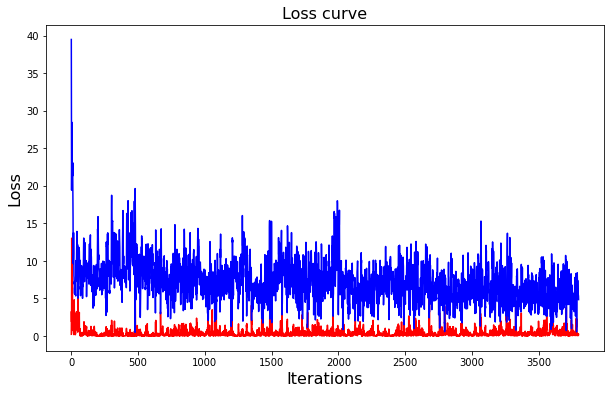

In [216]:
# 시각화

fig, axes = plt.subplots(1,1,figsize=(10,6))
axes.plot(d_loss,label="Discriminator",color='red')
axes.plot(g_loss,label="Generator",color='blue')
axes.set_title('Loss curve',size=16)
axes.set_xlabel('Iterations',size=16)
axes.set_ylabel('Loss',size=16)

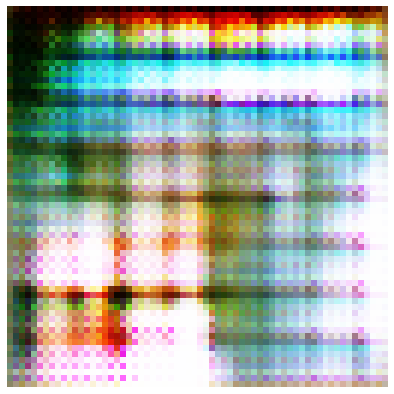

In [217]:
fig = plt.figure(figsize=(10,7))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())